## Notes:
BART is a pre-trained transformer model. 

The MNLI fine-tuned version from huggingface is used for zero-shot sentiment classification (which is described [here](https://huggingface.co/facebook/bart-large-mnli) )

For speed, it may be better to fine-tune smaller versions of BART on the available dataset.

In [1]:
import torch
from transformers import BartForSequenceClassification, BartTokenizer
from transformers import TrainingArguments, DataCollatorWithPadding

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

from src.bart_utils import BartZeroShot

In [2]:
bzs = BartZeroShot()

In [3]:
import numpy as np
from src.data_utils import TwitterDataClass, TorchTwitterDataset
seed = 1337
np.random.seed(seed)
tw = TwitterDataClass(load_cached_stage = 1)
d_train, d_test = tw.train_test_split()

In [20]:
from tqdm import tqdm

batch_size = 128
preds = []
_ = bzs.nli_model.eval()
for bstart in tqdm(range(0, len(d_test), batch_size)):
    messages = d_test['message'][bstart:bstart+batch_size].values
    with torch.no_grad():
        preds.append((bzs.predict_batched(messages, 'positive').cpu().numpy())*1)

100%|██████████| 3122/3122 [08:01<00:00,  6.48it/s]


In [28]:
p = np.hstack(preds)

In [29]:
import matplotlib.pyplot as pplot
import pandas as pd

In [30]:
accs = []
for pp in np.linspace(0.01, .9, 100):
    acc = np.sum(d_test[:p.shape[0]]['is_positive'] == (p > pp)) / d_test.shape[0]
    accs.append({'accuracy' : acc, 'p_thresh' : pp})
accs = pd.DataFrame(accs)

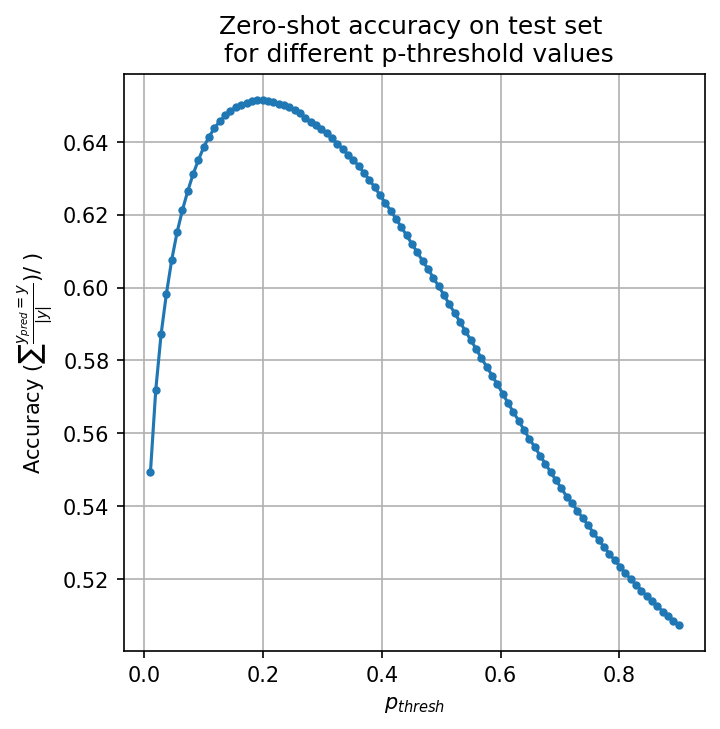

In [31]:
v1 = accs['accuracy'].values
pp = accs['p_thresh'].values
pplot.figure(figsize = (5,5), dpi = 150)
pplot.plot(pp, v1,'.-')
pplot.title('Zero-shot accuracy on test set \n for different p-threshold values')
pplot.xlabel('$p_{thresh}$')
pplot.ylabel('Accuracy $ ( \sum \\frac{y_{pred} = y}{|y|})/$ )')
pplot.grid()

In [32]:
from src.utils import binary_model_diagnostics

In [33]:
binary_model_diagnostics(d_test['is_positive'].values[:len(p)], p > 0.2)

{'tn': np.float64(0.638512888466635),
 'tp': np.float64(0.6644412366173463),
 'fp': np.float64(0.36234411965195074),
 'fn': np.float64(0.3347651073830537),
 'accuracy': np.float64(0.6514617131042285),
 'precision': np.float64(0.6471082125981177),
 'recall': np.float64(0.6644412366173463),
 'f1': np.float64(0.6556601907173664)}

In [34]:
d_test.shape[0]

399497

In [35]:
d_train.shape[0]

1198488

In [36]:
binary_model_diagnostics(d_test['is_positive'].values[:len(p)], p > 0.5)

{'tn': np.float64(0.9196539740480536),
 'tp': np.float64(0.2779131079834797),
 'fp': np.float64(0.08053650908216047),
 'fn': np.float64(0.7203790284271321),
 'accuracy': np.float64(0.5991634480359052),
 'precision': np.float64(0.7753198629658113),
 'recall': np.float64(0.2779131079834797),
 'f1': np.float64(0.4091621867931977)}